In [ ]:
%%capture
# give permissions to kaggle API
! pip install kaggle
! mkdir /root/.kaggle
! cp kaggle.json /root/.kaggle
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
%%capture
# download dataset from kaggle to colab
! kaggle datasets download -d samratadhikari/bird-mel-spectrogram-dataset-v2
! unzip /content/bird-mel-spectrogram-dataset-v2.zip -d /content/

In [ ]:
# remove uncessary files
! rm -r /content/bird-mel-spectrogram-dataset-v2.zip
! rm -r /content/kaggle.json
! rm -r /content/sample_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Initialization

In [ ]:
import os
import pandas as pd
import seaborn as sns
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random

import tensorflow as tf
from tensorflow import math
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB3
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
TRAIN_PATH = '/content/mel_spectrogram_dataset_v2/train'
VAL_PATH = '/content/mel_spectrogram_dataset_v2/val'
TEST_PATH = '/content/mel_spectrogram_dataset_v2/test'

In [ ]:
BIRDS = [name for name in os.listdir(TRAIN_PATH) if os.path.isdir(os.path.join(TRAIN_PATH, name))]

In [ ]:
file_path = './birds_classes_v3.txt'
with open(file_path, 'w') as f:
    for bird in BIRDS:
        f.write(f"{bird}\n")

### Preparing the data

**Hyperparameters**

In [ ]:
BATCH_SIZE = 4
IMG_SIZE = (128, 128)
NO_CLASSES = len(BIRDS)
LR = 0.0001
LOSS = "categorical_crossentropy"
EPOCHS = 30

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode="nearest",
)
train_batches = train_datagen.flow_from_directory(
    TRAIN_PATH,
    classes=BIRDS,
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(
    VAL_PATH,
    classes=BIRDS,
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_batches = test_datagen.flow_from_directory(
    TEST_PATH,
    classes=BIRDS,
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

Found 14350 images belonging to 41 classes.
Found 4100 images belonging to 41 classes.
Found 2050 images belonging to 41 classes.


### Model Architecture

In [ ]:
model = EfficientNetB3(
    include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Flatten and add Dropout
x = model.output
x = Flatten()(x)
x = Dropout(0.3)(x)

# Dense layer with L2 regularization
output_layer = Dense(len(BIRDS), activation="softmax", kernel_regularizer=l2(1e-4), name="softmax")(x)
model = Model(inputs=model.input, outputs=output_layer)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
logs_directory = 'efficientNet/logs/'

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=3,
                              restore_best_weights=True,
                              verbose=False)

def scheduler(epoch, lr):
    decay = -0.1
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * math.exp((epoch + 1) * decay))

lrscheduler = LearningRateScheduler(scheduler)

checkpoint = ModelCheckpoint(
    r"efficientNet/model_checkpoint.keras",
    monitor="val_loss",
    verbose=False,
    save_best_only=True,
    mode="auto",
)

callbacks = [checkpoint, lrscheduler, early_stopping]

In [ ]:
model.compile(optimizer=Adam(learning_rate=LR), loss=LOSS, metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=EPOCHS,
    callbacks= callbacks,
    verbose=True)

Epoch 1/30
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 358s 66ms/step - accuracy: 0.2877 - loss: 2.8006 - val_accuracy: 0.6961 - val_loss: 1.1348 - learning_rate: 1.0000e-04
Epoch 2/30
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 183s 45ms/step - accuracy: 0.6577 - loss: 1.2375 - val_accuracy: 0.7795 - val_loss: 0.8245 - learning_rate: 1.0000e-04
Epoch 3/30
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 166s 46ms/step - accuracy: 0.7568 - loss: 0.8685 - val_accuracy: 0.8422 - val_loss: 0.6119 - learning_rate: 1.0000e-04
Epoch 4/30
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 159s 44ms/step - accuracy: 0.7947 - loss: 0.7295 - val_accuracy: 0.8551 - val_loss: 0.5737 - learning_rate: 1.0000e-04
Epoch 5/30
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 166s 46ms/step - accuracy: 0.8283 - loss: 0.6240 - val_accuracy: 0.8639 - val_loss: 0.5472 - learning_rate: 1.0000e-04
Epoch 6/30
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 181s 50ms/step - accuracy: 0.8719 - loss: 0.4503 - val_accuracy: 0.8900 - val_loss: 0.4511 - learning_rate: 5.4881e-05
Epoch 7/30
3588/3588 ━━━━━━━━━━━━━

In [ ]:
model.save('/content/drive/MyDrive/Models/FeatherFind/efficientNet_model_v3.keras', include_optimizer=True)
model.save_weights('/content/drive/MyDrive/Models/FeatherFind/efficientNet_model_weights_v3.weights.h5')
! cp /content/birds_classes_v3.txt /content/drive/MyDrive/Models/FeatherFind/

### Evaluation

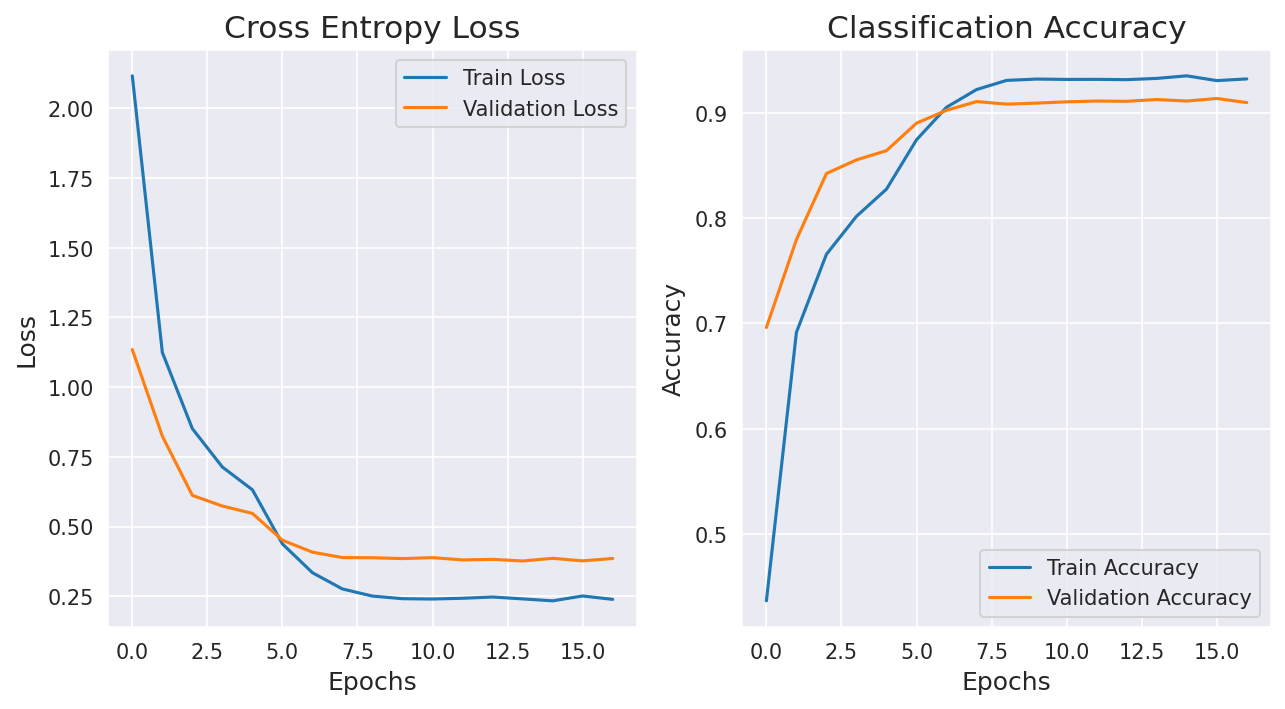

In [ ]:
metrics = pd.DataFrame(history.history)

plt.figure(figsize=(10, 5), dpi=150)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
loss, acc = model.evaluate(test_batches, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

The accuracy of the model for testing data is: 89.36585187911987
The Loss of the model for testing data is: 0.42969849705696106


In [ ]:
predicted_class = model.predict(test_batches, verbose=False)
predicted_class_indices = np.argmax(predicted_class, axis=1)
actual_class_indices = test_batches.classes

correct = np.nonzero(predicted_class_indices == actual_class_indices)[0]
incorrect = np.nonzero(predicted_class_indices != actual_class_indices)[0]

print("Correctly predicted classes:", correct.shape[0])
print("Incorrectly predicted classes:", incorrect.shape[0])

Correctly predicted classes: 1832
Incorrectly predicted classes: 218


513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


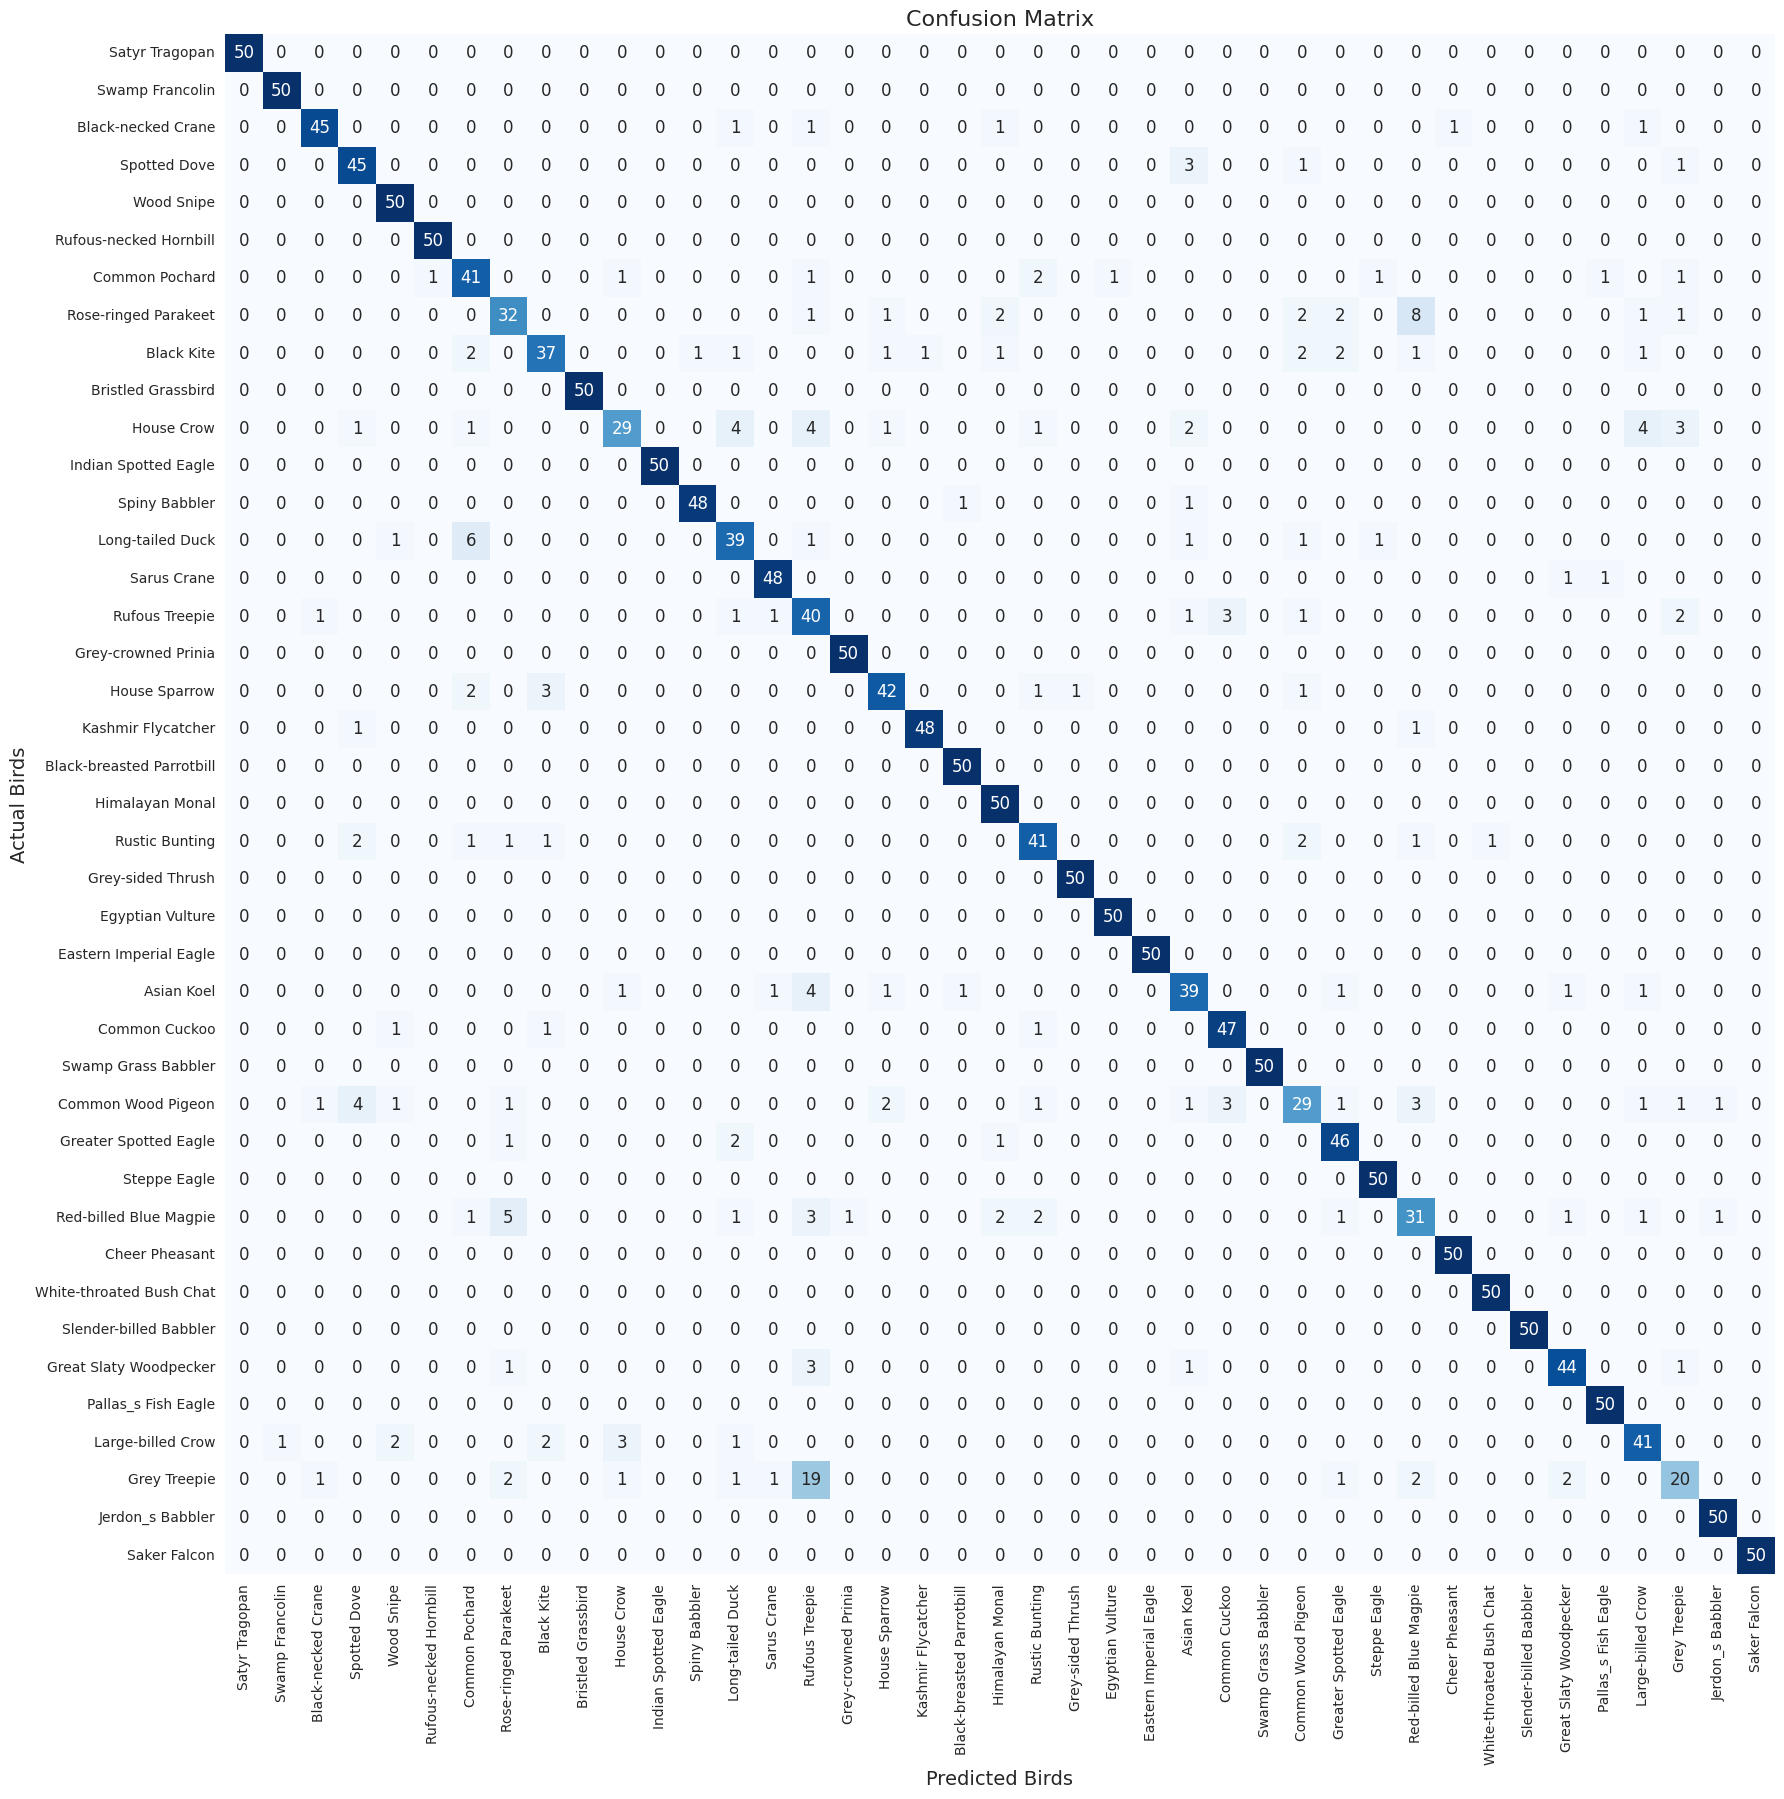

In [ ]:
def confusion_matrix_plot(model, test_batches):
    # Predict and get true labels
    preds = model.predict(test_batches)
    y_preds = np.argmax(preds, axis=-1)
    y_true = test_batches.classes

    # Generate confusion matrix and convert to DataFrame
    confuse = confusion_matrix(y_true, y_preds)
    conf_df = pd.DataFrame(confuse, index=BIRDS, columns=BIRDS)

    # Plot heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='d', annot_kws={'size': 12}, cbar=False)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Birds', fontsize=14)
    plt.ylabel('Actual Birds', fontsize=14)

    # Save the plot
    plt.savefig('Confusion_Matrix.png', dpi=200, bbox_inches='tight')

# Example usage
confusion_matrix_plot(model, test_batches)

513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step


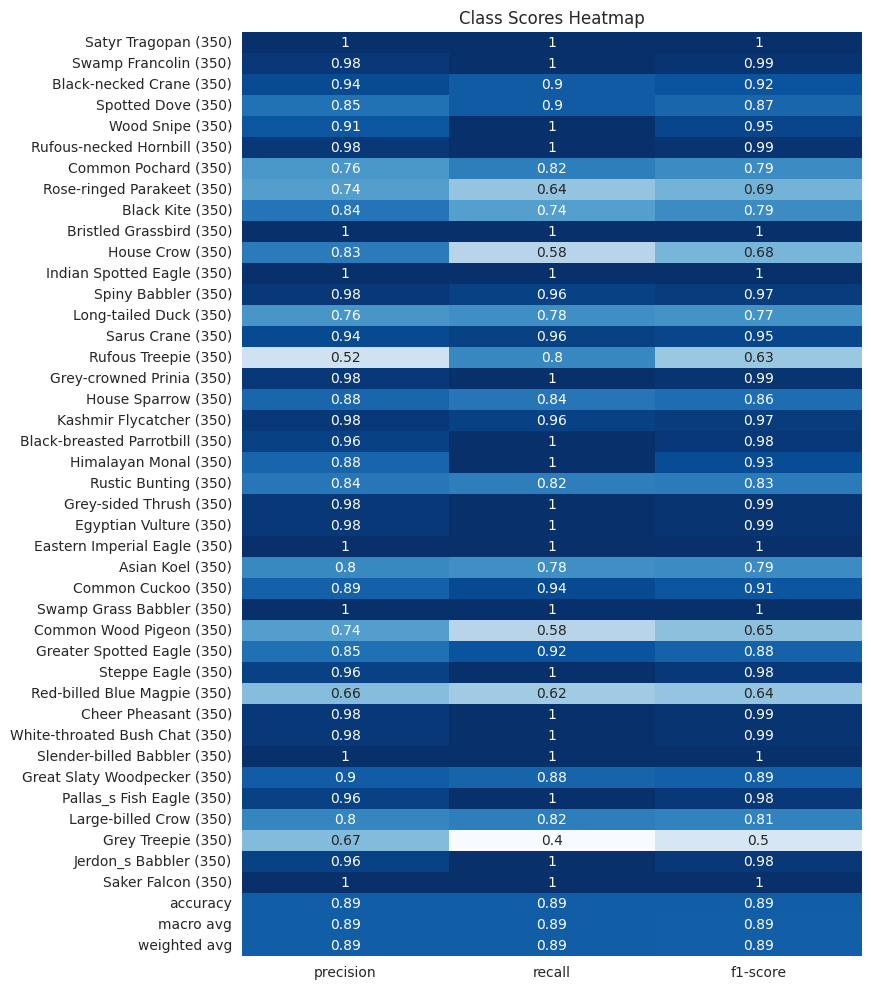

In [ ]:
def class_scores(classes_dir, model, test_batches):

    # Count images per class in the training set
    birds_train_count = {f: len(os.listdir(os.path.join(classes_dir, f))) for f in os.listdir(classes_dir)}
    birds_train_count = dict(sorted(birds_train_count.items(), key=lambda x: x[1], reverse=True))

    # Predict and generate classification report
    preds = model.predict(test_batches)
    y_preds = np.argmax(preds, axis=-1)
    y_true = test_batches.classes
    clf_report = classification_report(y_true, y_preds, output_dict=True)

    # Create DataFrame and reindex by class counts
    cls_df = pd.DataFrame(clf_report).iloc[:-1, :].T
    cls_df = cls_df.reindex([str(BIRDS.index(bird)) for bird in birds_train_count.keys()] + ['accuracy', 'macro avg', 'weighted avg'])
    cls_df.index = [f"{k} ({v})" for k, v in birds_train_count.items()] + ['accuracy', 'macro avg', 'weighted avg']

    # Plot heatmap with blue color palette
    plt.figure(figsize=(8, 12))
    sns.heatmap(cls_df, annot=True, cmap='Blues', cbar=False)
    plt.title('Class Scores Heatmap')
    plt.savefig('Classes_with_Scores_Heatmap.png', dpi=200, bbox_inches='tight')

class_scores(TRAIN_PATH, model, test_batches)

### Prediction

In [ ]:
file_path = '/content/drive/MyDrive/Models/FeatherFind/birds_classes_v3.txt'
with open(file_path, 'r') as f:
    BIRDS = [line.strip() for line in f]

In [ ]:
BIRDS

['Satyr Tragopan',
 'Swamp Francolin',
 'Black-necked Crane',
 'Spotted Dove',
 'Wood Snipe',
 'Rufous-necked Hornbill',
 'Common Pochard',
 'Rose-ringed Parakeet',
 'Black Kite',
 'Bristled Grassbird',
 'House Crow',
 'Indian Spotted Eagle',
 'Spiny Babbler',
 'Long-tailed Duck',
 'Sarus Crane',
 'Rufous Treepie',
 'Grey-crowned Prinia',
 'House Sparrow',
 'Kashmir Flycatcher',
 'Black-breasted Parrotbill',
 'Himalayan Monal',
 'Rustic Bunting',
 'Grey-sided Thrush',
 'Egyptian Vulture',
 'Eastern Imperial Eagle',
 'Asian Koel',
 'Common Cuckoo',
 'Swamp Grass Babbler',
 'Common Wood Pigeon',
 'Greater Spotted Eagle',
 'Steppe Eagle',
 'Red-billed Blue Magpie',
 'Cheer Pheasant',
 'White-throated Bush Chat',
 'Slender-billed Babbler',
 'Great Slaty Woodpecker',
 'Pallas_s Fish Eagle',
 'Large-billed Crow',
 'Grey Treepie',
 'Jerdon_s Babbler',
 'Saker Falcon']

## Prediction

In [ ]:
SAMPLE_RATE = 32000
DURATION = 10
MIN_DURATION = 5
N_MELS = 48
WIN_SIZE = 1024
HOP_SIZE = 512
WINDOW_TYPE = 'hann'
FMIN = 500
FMAX = 12500
IMG_SIZE = (128, 128)

In [ ]:
model_path = '/content/drive/MyDrive/Models/FeatherFind/efficientNet_model_v3.keras'
model = load_model(model_path, compile=True)
model.trainable = False

In [ ]:
## using weights
base_model = EfficientNetB3(
    include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

x = base_model.output
x = Flatten()(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(BIRDS), activation="softmax", kernel_regularizer=l2(1e-4), name="softmax")(x)

model = Model(inputs=base_model.input, outputs=output_layer)

model.compile()

model_weights_path = '/content/drive/MyDrive/Models/FeatherFind/efficientNet_model_weights_v3.weights.h5'
model.load_weights(model_weights_path)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Audio processing

In [ ]:
!rm -r /content/inference_temp

rm: cannot remove '/content/inference_temp': No such file or directory


In [ ]:
def split_audio(audio, sr, target_duration=DURATION, min_duration=MIN_DURATION):
    """Split audio into 10-second segments, padding to 10 seconds if between 5-10s, and ignore if <5s."""
    target_length = target_duration * sr
    min_length = min_duration * sr
    audio_splits = []

    for start in range(0, len(audio), target_length):
        split_audio = audio[start:start + target_length]

        if len(split_audio) >= min_length:
            if len(split_audio) < target_length:
                padding_length = target_length - len(split_audio)
                split_audio = np.pad(split_audio, (0, padding_length), mode='reflect')

            audio_splits.append(split_audio)

    return audio_splits

def generate_mel_spectrogram(signal, save_path, sr=SAMPLE_RATE):
    """Generate a mel spectrogram image from an audio signal and save it."""
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=WIN_SIZE,
                                       hop_length=HOP_SIZE, n_mels=N_MELS,
                                       fmin=FMIN, fmax=FMAX, window=WINDOW_TYPE)
    mel_spec = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(5, 5))
    librosa.display.specshow(mel_spec, sr=sr, fmin=FMIN, fmax=FMAX, y_axis='linear')
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def process_audio(audio_path):
    """split audio, generate mel spectrograms"""

    audio, sr = librosa.load(audio_path)
    audio_segments = split_audio(audio, sr)

    inference_folder = "inference_temp"
    os.makedirs(inference_folder, exist_ok=True)

    for i, segment in enumerate(audio_segments):
        mel_spec_path = f"{inference_folder}/mel_spec_{i}.png"
        generate_mel_spectrogram(segment, mel_spec_path, sr)

    mel_image_paths = [f"{inference_folder}/mel_spec_{i}.png" for i in range(len(audio_segments))]
    print(f"Generated Mel Spectrograms: {mel_image_paths}")


audio_path = "/content/Call of the Maldivian house crow.mp3"
process_audio(audio_path)

Generated Mel Spectrograms: ['inference_temp/mel_spec_0.png', 'inference_temp/mel_spec_1.png', 'inference_temp/mel_spec_2.png']


### Mel Spectrogram processing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


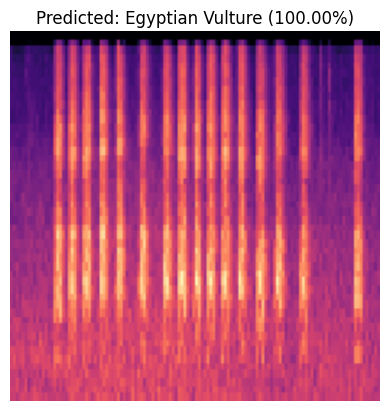

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


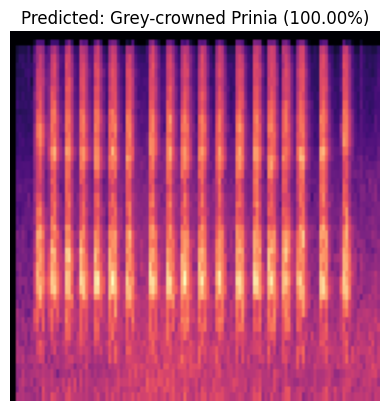

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


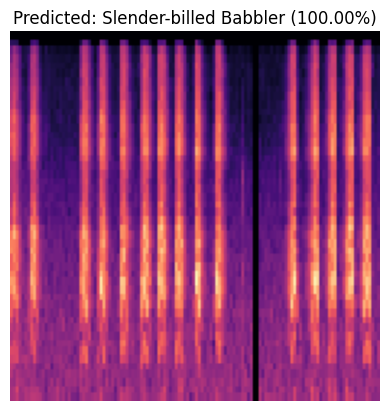


Predicted class: Egyptian Vulture


In [ ]:
def load_and_preprocess_image(image_path, target_size=IMG_SIZE):
    """
    Load and preprocess a mel spectrogram image.
    This function will resize, preprocess, and convert the image to the correct format.
    """
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_bird_class(image_path):
    """
    Load a single image, preprocess it, and make a prediction.
    """

    img_array = load_and_preprocess_image(image_path)

    predictions = model.predict(img_array)

    predicted_class_index = np.argmax(predictions)
    predicted_class_name = BIRDS[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100

    # print(f"Predicted class: {predicted_class_name} with {confidence:.2f}% confidence")
    return predicted_class_name, confidence

def process_and_predict_from_folder(folder_path):
    """
    Iterate over all images in the folder, make predictions, and display them.
    Also, return the predicted class with the highest frequency.
    If there's a tie, return the class with the highest confidence.
    """
    image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path)]

    predicted_classes = []
    confidences = []

    for img_path in image_paths:
        predicted_class, confidence = predict_bird_class(img_path)
        predicted_classes.append(predicted_class)
        confidences.append(confidence)

        img = image.load_img(img_path, target_size=IMG_SIZE)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
        plt.axis("off")
        plt.show()

    class_counts = Counter(predicted_classes)
    most_common_classes = class_counts.most_common()

    # Check for tie and select the class with highest confidence
    highest_freq = most_common_classes[0][1]
    candidates = [cls for cls, count in most_common_classes if count == highest_freq]

    # If there's a tie, compare their confidence values
    if len(candidates) > 1:
        max_confidence = -1
        best_class = None

        for cls in candidates:
            indices = [i for i, c in enumerate(predicted_classes) if c == cls]
            max_conf = max([confidences[i] for i in indices])
            if max_conf > max_confidence:
                max_confidence = max_conf
                best_class = cls
        most_common_prediction = best_class
    else:
        most_common_prediction = candidates[0]

    print(f"\nPredicted class: {most_common_prediction}")

inference_folder = "/content/inference_temp"
process_and_predict_from_folder(inference_folder)


## Image Only

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted class: Slender-billed Babbler with 100.00% confidence


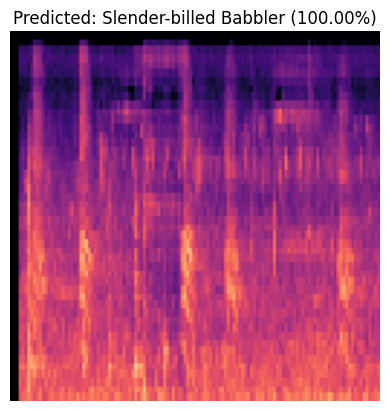

In [ ]:
def load_and_preprocess_image(image_path, target_size=IMG_SIZE):
    """
    Load and preprocess a mel spectrogram image.
    This function will resize, preprocess and convert the image to the correct format.
    """
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_bird_class(image_path):
    """
    Load a single image, preprocess it and make a prediction.
    """

    img_array = load_and_preprocess_image(image_path)

    predictions = model.predict(img_array)

    predicted_class_index = np.argmax(predictions)
    predicted_class_name = BIRDS[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100

    print(f"Predicted class: {predicted_class_name} with {confidence:.2f}% confidence")
    return predicted_class_name, confidence

test_image_path = "/content/inference_temp/mel_spec_0.png"
predicted_class, confidence = predict_bird_class(test_image_path)

img = image.load_img(test_image_path, target_size=IMG_SIZE)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
plt.axis("off")
plt.show()